In [63]:
import urllib
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from beautifultable import BeautifulTable

In [64]:
featureNames = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 
                'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']
classNames = ['normal', 'abnormal']
allTrainingErrors = {}

In [65]:
def readData(dataURL):
    dataX = []
    dataY = []
    inputFile = urllib.request.urlopen(dataURL)
    for line in inputFile:
        line = line.decode('utf-8')
        variables = line.split(' ')
        features = variables[:len(variables)-1]
        label = variables[len(variables)-1].strip()
        dataX.append(features)
        if label=='NO':
            dataY.append(0)
        else:
            dataY.append(1)
    
    return dataX, dataY

In [66]:
# Splits dataset into classes
def getGroupData(dataX, dataY):
    NODataX = []
    NODataY  = []
    ABDataX = []
    ABDataY = []
    
    for i in range(0, len(dataY)):
        if dataY[i]==0:
            NODataX.append(dataX[i])
            NODataY.append(dataY[i])
        else:
            ABDataX.append(dataX[i])
            ABDataY.append(dataY[i])

    NODataX = np.asarray(NODataX)
    NODataY = np.asarray(NODataY)
    ABDataX = np.asarray(ABDataX)
    ABDataY = np.asarray(ABDataY)

    return NODataX, NODataY, ABDataX, ABDataY

In [67]:
# Returns all the observation values for a particular feature
def getFeatureData(dataX, dataY, featureIdx):
    classNOData = []
    classABData = []
    for i in range(0, len(dataX)):
        featureData = float(dataX[i][featureIdx])
        if dataY[i]==0:
            classNOData.append(featureData)
        else:
            classABData.append(featureData)

    return classNOData, classABData

In [68]:
# Draw scatter plot for each pair of independent variables in the dataset
def drawScatterplot(dataX, dataY):
    colors = ['red', 'blue']
    for i in range(0, len(featureNames)):
        for j in range(i+1, len(featureNames)):
            # Get all observation values for feature i and feature j
            classNOData1, classABData1 = getFeatureData(dataX, dataY, i)
            classNOData2, classABData2 = getFeatureData(dataX, dataY, j)

            # draw scatterplot separated by class labels
            plt.scatter(classNOData1, classNOData2, 
                        c = colors[0], 
                        label = classNames[0], 
                        marker = '^')
            
            plt.scatter(classABData1, classABData2, 
                        c = colors[1], 
                        label = classNames[1], 
                        marker = 'o')

            plt.xlabel(featureNames[i])
            plt.ylabel(featureNames[j])
            plt.legend()
            plt.show()

In [69]:
# Change the color of boxplot 
def setColor(bp, idx, color):
    plt.setp(bp['boxes'][idx], color=color)
    plt.setp(bp['whiskers'][2*idx], color=color)
    plt.setp(bp['whiskers'][2*idx+1], color=color)
    plt.setp(bp['medians'][idx], color=color)
    return bp

In [95]:
# Draw box plot for each independent variable in the dataset
def drawBoxplot(dataX, dataY):
    # create a grid with 1 row and 6 columns
    fig, ax = plt.subplots(nrows = 1, 
                           ncols = 6, 
                           figsize = (20, 7))

    for i in range(0, len(featureNames)):
        # get all observation values for feature i
        classNOData, classABData = getFeatureData(dataX, dataY, i)
        featureData = []
        featureData.append(classNOData)
        featureData.append(classABData)

        # draw boxplot for feature i separated by class labels
        bp = ax[i].boxplot(featureData, widths = 0.5)
        bp = setColor(bp, 0, 'r')
        bp = setColor(bp, 1, 'b')
        ax[i].set_xticklabels(classNames)
        ax[i].set_title(featureNames[i])

    fig.subplots_adjust(wspace = 0.3)
    plt.show()

In [71]:
# Splits dataset into training data and testing data
def getTrainTestData(dataX, dataY):
    trainDataX = []
    trainDataY = []
    testDataX = []
    testDataY = []
    trainNOCnt = 0
    trainABCnt = 0

    for i in range(0, len(dataY)):
        if dataY[i]==0:
            # first 70 observations will go in training set 
            if trainNOCnt<70:
                trainDataX.append(dataX[i])
                trainDataY.append(dataY[i])
                trainNOCnt += 1
            else:
                testDataX.append(dataX[i])
                testDataY.append(dataY[i])
        else:
            # first 140 observations will go in training set
            if trainABCnt<140:
                trainDataX.append(dataX[i])
                trainDataY.append(dataY[i])
                trainABCnt += 1
            else:
                testDataX.append(dataX[i])
                testDataY.append(dataY[i])

    trainDataX = np.asarray(trainDataX)
    trainDataX = trainDataX.astype(np.float64)
    
    trainDataY = np.asarray(trainDataY)
    
    testDataX = np.asarray(testDataX)
    testDataX = testDataX.astype(np.float64)
    
    testDataY = np.asarray(testDataY)
    
    return trainDataX, trainDataY, testDataX, testDataY

In [72]:
# Plot train and test error for different values of K
def plotTrainTestError(trainErrorDict, testErrorDict, metric, trainLabel, testLabel, KStart, KEnd):
    # plot K vs training error 
    plt.plot(trainErrorDict.keys(), trainErrorDict.values(), 'r', label = trainLabel)
        
    # plot K vs testing error
    plt.plot(testErrorDict.keys(), testErrorDict.values(), 'b', label = testLabel)
    
    plt.title('Error vs Value of K using ' + metric + ' distance metric')
    plt.xlim(KStart, KEnd)
    plt.ylabel('Error Rate')
    plt.xlabel('Value of K')
    plt.legend()
    plt.show()

In [73]:
# Plot learning curve
def plotLearningCurve(errorDict, metric):
    plt.plot(errorDict.keys(), errorDict.values(), 'b')
    plt.title('Learning curve using ' + metric + ' distance metric')
    plt.ylabel('Error Rate')
    plt.xlabel('Training Set Size')
    plt.show()

In [74]:
# Perform KNN classifier
def KNN(trainDataX, trainDataY, testDataX, testDataY, metric, p, polling, KStart, KEnd, KChange):
    errorDict = {}
    confusionMatrixDict = {}

    # compute testing error for different values of K
    while True:
        if metric=='mahalanobis':
            dataX = np.concatenate((trainDataX, testDataX), axis=0)
            dataY = np.concatenate((trainDataY, testDataY), axis=0)
            
            # compute covariance matrix
            covarianceMatrix = computeCovarianceMatrix(dataX, dataY)
            
            KNN = KNeighborsClassifier(n_neighbors = KStart, 
                                       algorithm = 'brute',
                                       metric = metric,
                                       metric_params = {'V': covarianceMatrix},
                                       weights = polling)
        elif metric=='minkowski':
            KNN = KNeighborsClassifier(n_neighbors = KStart, 
                                       metric = metric,
                                       p = p,
                                       weights = polling)
        else:
            KNN = KNeighborsClassifier(n_neighbors = KStart, 
                                       metric = metric,
                                       weights = polling)

        # Fit training data on KNN classifier model
        KNN.fit(trainDataX, trainDataY)
        
        # get predictions on fitted KNN model for test data
        predictedY = KNN.predict(testDataX)
        
        # compute prediction error on test data 
        accuracy = KNN.score(testDataX, testDataY)
        error = 1-round(accuracy, 3)
        errorDict[KStart] = error
        
        # compute confusion matrix
        confusionMatrix = confusion_matrix(testDataY, 
                                           predictedY, 
                                           labels = [1, 0])
        confusionMatrixDict[KStart] = confusionMatrix

        if KStart==KEnd:
            break
        KStart += KChange
        
        if KStart>len(trainDataX):
            break

    return errorDict, confusionMatrixDict

In [75]:
# Compute model measures: True Positive Rate, True Negative Rate,
# Precision and FScore
def getModelMeasures(errorDict, confusionMatrixDict):
    # sort error dictionary based on dictionary values(error)
    sortedError = sorted(errorDict.items(), key=operator.itemgetter(1))

    # Value of K with least error
    bestK = sortedError[0][0]
    leastError = sortedError[0][1]

    # Confusion matrix
    confusionMatrix = confusionMatrixDict[bestK]

    # True Positive, True Negative, False Positive and False Negative
    truePositive = confusionMatrix[0][0]
    falseNegative = confusionMatrix[0][1]
    falsePositive = confusionMatrix[1][0]
    trueNegative = confusionMatrix[1][1]
    
    # True Positive Rate, True Negative Rate, Precision and F1-Score
    truePositiveRate = round(truePositive / (truePositive + falseNegative), 2)
    trueNegativeRate = round(trueNegative / (trueNegative + falsePositive), 2)
    precision = round(truePositive / (truePositive + falsePositive), 2)
    f1Score = round(2 * precision * truePositiveRate / (precision + truePositiveRate), 2)

    measures = []
    measures.append(bestK)
    measures.append(confusionMatrix)
    measures.append(truePositiveRate)
    measures.append(trueNegativeRate)
    measures.append(precision)
    measures.append(f1Score)

    return measures, leastError

In [76]:
# Perform KNN classification, plot learning and 
# compute model measures
def performClassification(trainDataX, trainDataY,
                          testDataX, testDataY,
                          metric, p, polling,
                          KStart, KEnd, KChange, 
                          plotFlag, reverseFlag):
    # compute training error on different values of K
    trainErrorDict, trainConfusionMatrixDict = KNN(trainDataX, trainDataY,
                                                   trainDataX, trainDataY,
                                                   metric, p, polling,
                                                   KStart, KEnd, KChange)
    
    # append all training errors in a dictionary
    for k, v in trainErrorDict.items():
        key = metric.strip() + ' ' + polling.strip() + ' ' + str(k)
        allTrainingErrors[key] = v

    # compute testing error on different values of K
    testErrorDict, testConfusionMatrixDict = KNN(trainDataX, trainDataY,
                                                 testDataX, testDataY,
                                                 metric, p, polling,
                                                 KStart, KEnd, KChange)
    
    # plot training error and testing error for different values of K
    if plotFlag:
        if reverseFlag:
            plotTrainTestError(trainErrorDict, testErrorDict, metric, 'Train Error', 'Test Error', KEnd, KStart)
        plotTrainTestError(trainErrorDict, testErrorDict, metric, 'Train Error', 'Test Error', KStart, KEnd)
        
    # compute model measures (True Positive Rate, True Negative Rate, Precision and F1-Score)
    measures, leastError = getModelMeasures(testErrorDict, testConfusionMatrixDict)
    return measures, leastError

In [77]:
# Find test error for different values of logP
def findLogPError(trainDataX, trainDataY, 
                  testDataX, testDataY, 
                  metric, k, polling):
    logPStart = 0.1
    logPIncrement = 0.1
    bestLogPValue = 0
    errorDict = {}
    
    # compute testing error for different values of logP
    while logPStart<=1.0:
        # round off 10^logP value to nearest integer
        p = round(math.pow(10, logPStart))
        KNN = KNeighborsClassifier(n_neighbors = k,
                                   metric = metric,
                                   p = p,
                                   weights = polling)
        
        # fit training data on KNN model
        KNN.fit(trainDataX, trainDataY)
        
        # compute predictions for test data
        predictedY = KNN.predict(testDataX)

        # compute testing error
        num_correct = np.sum(predictedY == testDataY)
        accuracy = float(num_correct) / len(testDataY)
        error = 1-round(accuracy, 3)
        errorDict[logPStart] = error
        logPStart = ((logPStart*10) + (logPIncrement*10))/10

    return errorDict

In [78]:
# Compute covariance matrix
def computeCovarianceMatrix(dataX, dataY):
    featureDataMatrix = []
    for i in range(0, 6):
        classNOData, classABData = getFeatureData(dataX, dataY, i)	
        featureData = classNOData + classABData
        featureDataMatrix.append(np.asarray(featureData))
    featureDataMatrix = np.asarray(featureDataMatrix)
    covarianceMatrix = np.cov(featureDataMatrix)
    return covarianceMatrix

In [79]:
# arrange data in a table
def printDatainTable(tableHeaders, tableData):
    table = BeautifulTable(max_width=100)
    table.column_headers = tableHeaders
    for i in range(0, len(tableData)):
        table.append_row(tableData[i])
    print(table)

# Read Vertebral Column Dataset.

In [91]:
dataX = []
dataY = []
 
dataURL = 'https://raw.githubusercontent.com/SurbhiJainUSC/KNN-Classifier/master/vertebral_column_data/column_2C.dat'
dataX, dataY = readData(dataURL)

# divide feature data for different classes
NODataX, NODataY, ABDataX, ABDataY = getGroupData(dataX, dataY)

# Scatterplot for all Independent Variables in the Dataset.

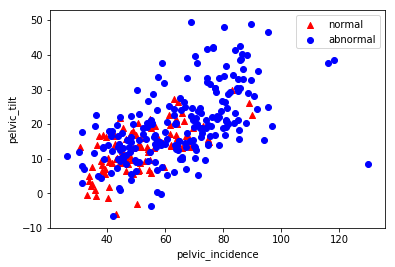

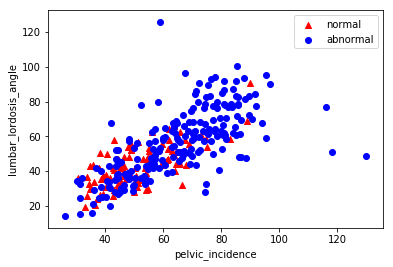

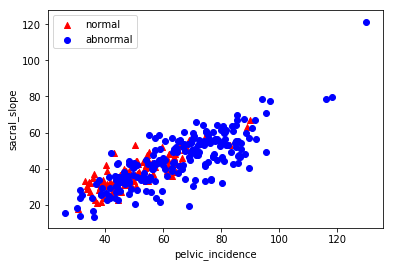

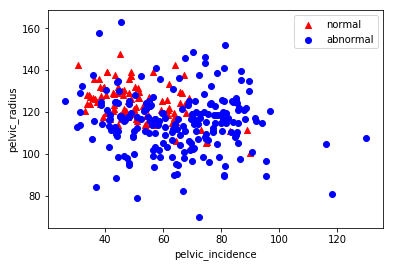

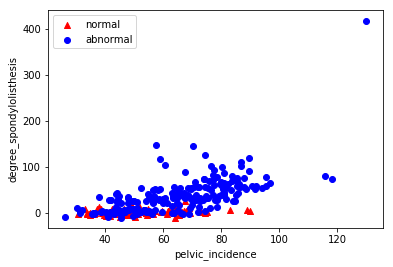

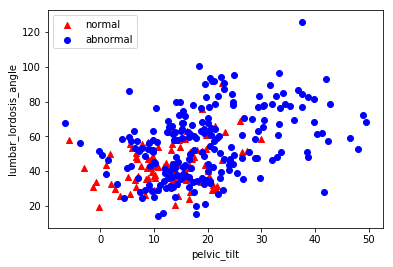

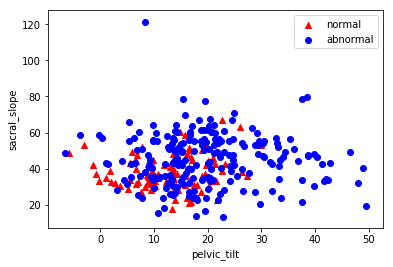

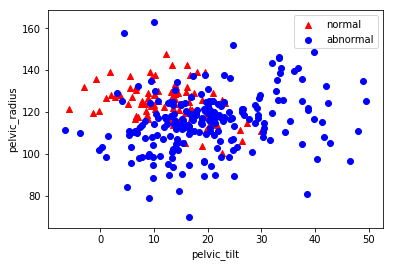

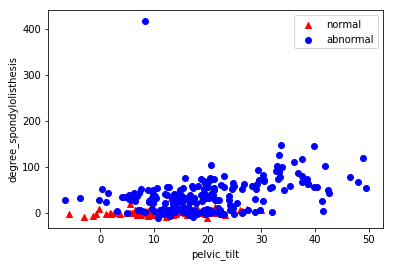

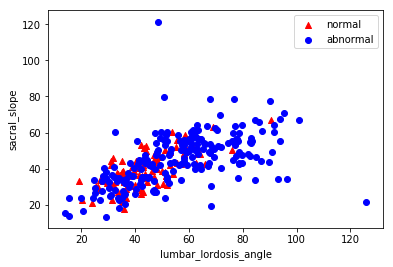

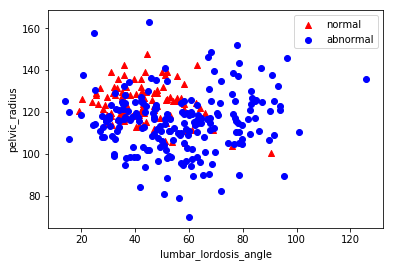

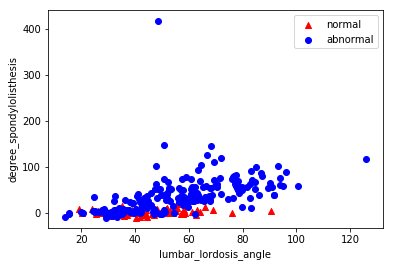

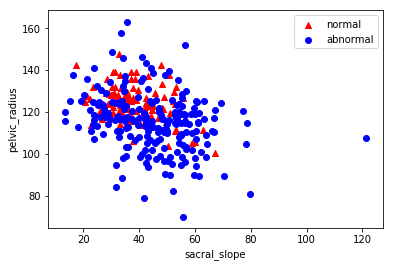

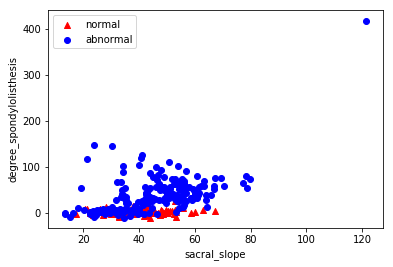

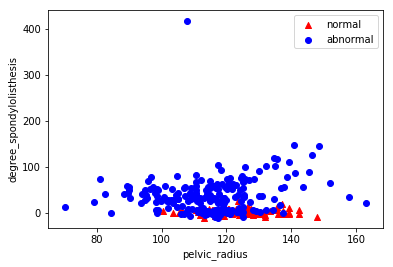

In [92]:
drawScatterplot(dataX, dataY)

# Box Plot for all Independent Variables.

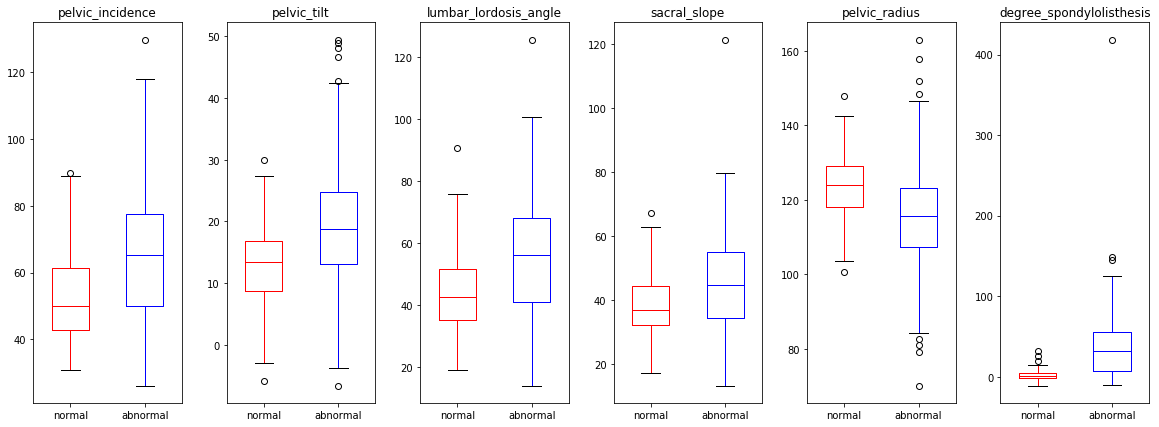

In [96]:
drawBoxplot(dataX, dataY)

# Split Dataset into Training Set and Testing Set.

In [97]:
trainDataX, trainDataY, testDataX, testDataY = getTrainTestData(dataX, dataY)

# KNN Classification using Euclidean Distance Metric and Majority Polling.

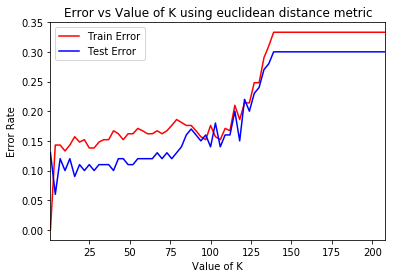

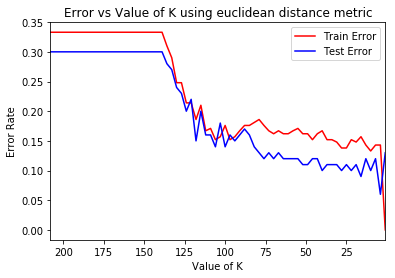

+--------+----------------+---------------+----------------+-----------------+-----------+---------+
| Best K | Least Test Err | Confusion Mat | True Positive  | True Negative R | Precision | F-Score |
|        |       or       |      rix      |      Rate      |       ate       |           |         |
+--------+----------------+---------------+----------------+-----------------+-----------+---------+
|   4    |      0.06      |   [[69  1]    |      0.99      |      0.83       |   0.93    |  0.96   |
|        |                |    [ 5 25]]   |                |                 |           |         |
+--------+----------------+---------------+----------------+-----------------+-----------+---------+


In [98]:
metric = 'euclidean'
polling = 'uniform'
KStart = 208
KEnd = 1
KChange = -3
measures, error = performClassification(trainDataX, trainDataY, testDataX, testDataY, 
                                 metric, 2, polling, KStart, KEnd, KChange, True, True)
tableHeaders = ["Best K", "Least Test Error", "Confusion Matrix", "True Positive Rate", 
                "True Negative Rate","Precision","F-Score"]
tableData = []
measures.insert(1, error)
tableData.append(measures)
printDatainTable(tableHeaders, tableData)

# Find Best K for Testing Set by Varying Size of Training Set.

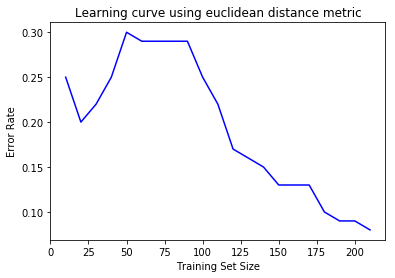

+----------+--------+------------+------------+-------------+---------------+-----------+----------+
| Training | Best K | Least Test | Confusion  | True Positi | True Negative | Precision | F1-Score |
|   Size   |        |    Error   |   Matrix   |   ve Rate   |      Rate     |           |          |
+----------+--------+------------+------------+-------------+---------------+-----------+----------+
|    10    |   1    |    0.25    |  [[65  5]  |    0.93     |     0.33      |   0.76    |   0.84   |
|          |        |            |  [20 10]]  |             |               |           |          |
+----------+--------+------------+------------+-------------+---------------+-----------+----------+
|    20    |   6    |    0.2     |  [[66  4]  |    0.94     |     0.47      |    0.8    |   0.86   |
|          |        |            |  [16 14]]  |             |               |           |          |
+----------+--------+------------+------------+-------------+---------------+-----------+--

In [99]:
tableData = []
trainNStart = 10
trainNIncrement = 10
trainNEnd = 210
errorDict = {}
while trainNStart<=trainNEnd:
    NOCnt = int(trainNStart/3)
    ABCnt = trainNStart - NOCnt
    trainDataX = np.concatenate((NODataX[:NOCnt], ABDataX[:ABCnt]), axis=0)
    trainDataY = np.concatenate((NODataY[:NOCnt], ABDataY[:ABCnt]), axis=0)
    trainDataX = trainDataX.astype(np.float64)

    metric = 'euclidean'
    polling = 'uniform'
    KStart = 1
    KEnd = 196
    KChange = 5
    measures, error = performClassification(trainDataX, trainDataY, 
                          testDataX, testDataY, 
                          metric, 2, polling,
                          KStart, KEnd, KChange, False, False)
    measures.insert(0, trainNStart)
    measures.insert(2, error)
    tableData.append(measures)
    errorDict[trainNStart] = error

    trainNStart += trainNIncrement
    
plotLearningCurve(errorDict, metric)
tableHeaders = ["Training Size", "Best K", "Least Test Error", "Confusion Matrix", 
                "True Positive Rate", "True Negative Rate","Precision","F1-Score"]
printDatainTable(tableHeaders, tableData)

In [100]:
comparisonData = []

# KNN Classification with Manhattan Distance Metric and Majority Polling.

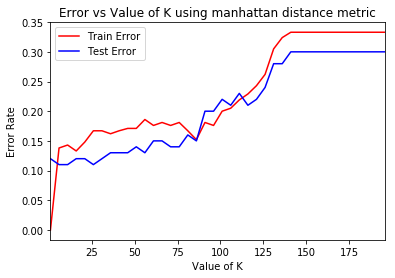

In [101]:
metric = 'manhattan'
polling = 'uniform'
KStart = 1
KEnd = 196
KChange = 5
manhattanMeasures, error = performClassification(trainDataX, trainDataY, 
                                                 testDataX, testDataY, 
                                                 metric, 1, polling,
                                                 KStart, KEnd, KChange, True, False)
manhattanMeasures.insert(0, 'Manhattan')
manhattanMeasures.insert(2, error)
comparisonData.append(manhattanMeasures)

# KNN Classification with Minkowski Distance Metric and Majority Polling.

In [102]:
metric = 'minkowski'
polling = 'uniform'
KStart = 1
KEnd = 196
KChange = 5
k = manhattanMeasures[1]
errorDict = findLogPError(trainDataX, trainDataY, testDataX, testDataY, metric, k, polling)
logPTableData = []
for k, v in errorDict.items():
    logPTableData.append([k, v])
print('Test Error for different values of logP')
tableHeaders = ["logP", "Least Test Error"]
printDatainTable(tableHeaders, logPTableData)
sortedError = sorted(errorDict.items(), key=operator.itemgetter(1))
print('Best logP value:', sortedError[0][0], 'with test error', round(sortedError[0][1], 2))

Test Error for different values of logP
+------+------------------+
| logP | Least Test Error |
+------+------------------+
| 0.1  |       0.11       |
+------+------------------+
| 0.2  |       0.08       |
+------+------------------+
| 0.3  |       0.08       |
+------+------------------+
| 0.4  |       0.08       |
+------+------------------+
| 0.5  |       0.08       |
+------+------------------+
| 0.6  |       0.06       |
+------+------------------+
| 0.7  |       0.07       |
+------+------------------+
| 0.8  |       0.08       |
+------+------------------+
| 0.9  |       0.09       |
+------+------------------+
| 1.0  |       0.09       |
+------+------------------+
Best logP value: 0.6 with test error 0.06


# KNN Classification with Chebyshev Distance Metric and Majority Polling.

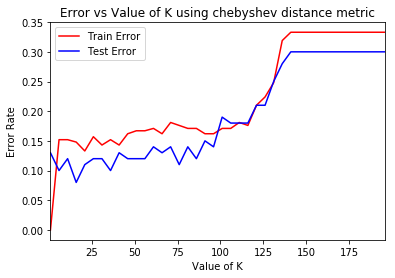

In [105]:
metric = 'chebyshev'
polling = 'uniform'
KStart = 1
KEnd = 196
KChange = 5
chebyshevMeasures, error = performClassification(trainDataX, trainDataY, 
                                                 testDataX, testDataY, 
                                                 metric, 0, polling,
                                                 KStart, KEnd, KChange, True, False)
chebyshevMeasures.insert(0, 'Chebyshev')
chebyshevMeasures.insert(2, error)
comparisonData.append(chebyshevMeasures)

# KNN Classification with Mahalanobis Distance Metric and Majority Polling.

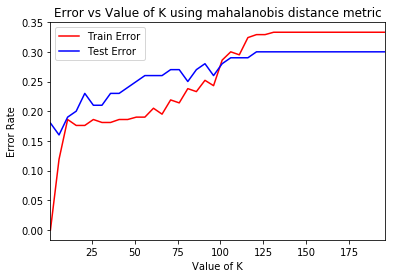

In [106]:
metric = 'mahalanobis'
polling = 'uniform'
KStart = 1
KEnd = 196
KChange = 5
mahalanobisMeasures, error = performClassification(trainDataX, trainDataY, 
                                                   testDataX, testDataY, 
                                                   metric, 0, polling,
                                                   KStart, KEnd, KChange, True, False)
mahalanobisMeasures.insert(0, 'Mahalanobis')
mahalanobisMeasures.insert(2, error)
comparisonData.append(mahalanobisMeasures)

# Comparion between Different Distance Metrics using Majority Polling.

In [108]:
tableHeaders = ["Distance Metric", "Best K", "Least Test Error", "Confusion Matrix", 
                "True Positive Rate", "True Negative Rate","Precision","F1-Score"]
printDatainTable(tableHeaders, comparisonData)

+-----------+--------+------------+------------+-------------+--------------+-----------+----------+
| Distance  | Best K | Least Test | Confusion  | True Positi | True Negativ | Precision | F1-Score |
|  Metric   |        |    Error   |   Matrix   |   ve Rate   |    e Rate    |           |          |
+-----------+--------+------------+------------+-------------+--------------+-----------+----------+
| Manhattan |   6    |    0.11    |  [[67  3]  |    0.96     |     0.73     |   0.89    |   0.92   |
|           |        |            |  [ 8 22]]  |             |              |           |          |
+-----------+--------+------------+------------+-------------+--------------+-----------+----------+
| Chebyshev |   16   |    0.08    |  [[70  0]  |     1.0     |     0.73     |    0.9    |   0.95   |
|           |        |            |  [ 8 22]]  |             |              |           |          |
+-----------+--------+------------+------------+-------------+--------------+-----------+--

In [109]:
distanceComparisonData = []

# KNN Classification with Manhattan Distance Metric and Weighted Polling.

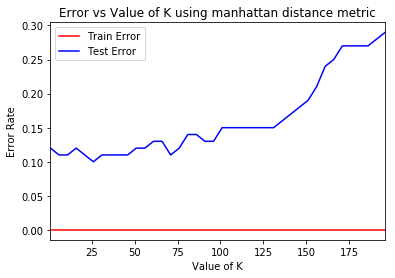

In [110]:
metric = 'manhattan'
polling = 'distance'
KStart = 1
KEnd = 196
KChange = 5
manhattanMeasures, error = performClassification(trainDataX, trainDataY, 
                                                 testDataX, testDataY, 
                                                 metric, 1, polling,
                                                 KStart, KEnd, KChange, True, False)
manhattanMeasures.insert(0, 'Manhattan')
manhattanMeasures.insert(2, error)
distanceComparisonData.append(manhattanMeasures)

# KNN Classification with Euclidean Distance Metric and Weighted Polling.

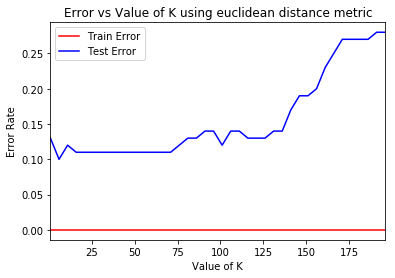

In [111]:
metric = 'euclidean'
polling = 'distance'
KStart = 1
KEnd = 196
KChange = 5
euclideanMeasures, error = performClassification(trainDataX, trainDataY, 
                                                 testDataX, testDataY, 
                                                 metric, 2, polling,
                                                 KStart, KEnd, KChange, True, False)
euclideanMeasures.insert(0, 'Euclidean')
euclideanMeasures.insert(2, error)
distanceComparisonData.append(euclideanMeasures)

# KNN Classification with Chebyshev Distance Metric and Weighted Polling.

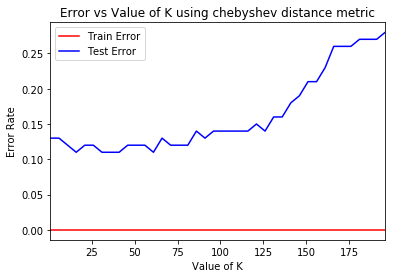

In [112]:
metric = 'chebyshev'
polling = 'distance'
KStart = 1
KEnd = 196
KChange = 5
chebyshevMeasures, error = performClassification(trainDataX, trainDataY, 
                                                 testDataX, testDataY, 
                                                 metric, 0, polling,
                                                 KStart, KEnd, KChange, True, False)
chebyshevMeasures.insert(0, 'Chebyshev')
chebyshevMeasures.insert(2, error)
distanceComparisonData.append(chebyshevMeasures)

# Comparison between Different Distance Metrics using Weighted Polling.

In [113]:
tableHeaders = ["Distance Metric", "Best K", "Least Test Error", "Confusion Matrix", 
                "True Positive Rate", "True Negative Rate","Precision","F1-Score"]
printDatainTable(tableHeaders, distanceComparisonData)

+-----------+--------+------------+------------+-------------+--------------+-----------+----------+
| Distance  | Best K | Least Test | Confusion  | True Positi | True Negativ | Precision | F1-Score |
|  Metric   |        |    Error   |   Matrix   |   ve Rate   |    e Rate    |           |          |
+-----------+--------+------------+------------+-------------+--------------+-----------+----------+
| Manhattan |   26   |    0.1     |  [[69  1]  |    0.99     |     0.7      |   0.88    |   0.93   |
|           |        |            |  [ 9 21]]  |             |              |           |          |
+-----------+--------+------------+------------+-------------+--------------+-----------+----------+
| Euclidean |   6    |    0.1     |  [[70  0]  |     1.0     |     0.67     |   0.88    |   0.94   |
|           |        |            |  [10 20]]  |             |              |           |          |
+-----------+--------+------------+------------+-------------+--------------+-----------+--

# Lowest Training Error in KNN Classification.

In [114]:
sortedTrainingErrors = sorted(allTrainingErrors.items(), key=operator.itemgetter(1))
print('Lowest training error:', sortedTrainingErrors[0][1])

Lowest training error: 0.0
